In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import math
import numpy as np
import sympy as sym
# Loading your IBM Q account(s)
#IBMQ.save_account('XXXX','https://quantum-computing.ibm.com/')
#IBMQ.update_account()
provider = IBMQ.load_account()


In [3]:
# setting Pauli Operators
i=sym.I
X = sym.Matrix([
    [0, 1],
    [1, 0]
])
Z = sym.Matrix([
    [1, 0],
    [0, -1]
])

In [37]:
def TimeEvolution(qubits,omega_tau,alpha):
    H = -1*i*(Z*sym.cos(alpha)*omega_tau + X*sym.sin(alpha)*omega_tau)
    expH = H.exp()
    re = sym.re(H.exp())
    im = sym.im(H.exp())
    
    theta =np.arccos(float( sym.sqrt( re[0,0]**2 + im[0,0]**2 )))*2
    xi = np.arcsin(float( -1*im[0,0] /  sym.sqrt( re[0,0]**2 + im[0,0]**2 ) )) - np.pi/2
    
    qubits.u3(theta,xi,xi+np.pi,1) # This Operator is symmetry.
       
    return qubits

In [38]:
# 2 Qubits Scattaring Process
def TwoQubitsScattaringOperation(qubits):
    qubits.u3(2*np.pi/3,0,np.pi,0) # Apply U3 on qubit 0
    qubits.u1(1.761,0) # Apply U1 on qubit 0
    qubits.cx(1,0)
    qubits.u3(-0.723,0,-0.523,0)
    qubits.u1(1.047,1)
    qubits.cx(1,0)
    qubits.u3(0.723,-1.27,0,0)
    return qubits

In [39]:
def TimeForwardingProcess(qubits):
    qubits = TimeEvolution(qubits,omega_tau,alpha)
    qubits = TwoQubitsScattaringOperation(qubits)
    qubits = TimeEvolution(qubits,omega_tau,alpha)
    return qubits

In [40]:
def CalculationPhase(real_part,imaginary_part):
    length = np.sqrt(real_part**2 + imaginary_part**2)
    #real_norm =  real_part / length
    imaginary_norm = imaginary_part / length
    if real_part >= 0  :
        Rad = np.arcsin(imaginary_norm)
    elif real_part < 0 and imaginary_part >=0 :
        Rad = np.pi - np.arcsin(imaginary_norm)  
    elif real_part < 0 and imaginary_part < 0 :
        Rad = -np.pi - np.arcsin(imaginary_norm)
    return Rad

In [41]:
def TimeReversalOperation(qubits):
    # Select the StatevectorSimulator from the Aer provider
    simulator = Aer.get_backend('statevector_simulator')
    # Execute and get counts
    
    result = execute(qubits , simulator).result()
    statevector = result.get_statevector(qubits,decimals=3)
    #plot_state_city(statevector, title='Measurement Phase')
    #statevector
    
    phase00 = CalculationPhase(np.real(statevector[0]) , np.imag(statevector[0]) )
    phase10 = CalculationPhase(np.real(statevector[1]) , np.imag(statevector[1]) )
    phase01 = CalculationPhase(np.real(statevector[2]) , np.imag(statevector[2]) )
    phase11 = CalculationPhase(np.real(statevector[3]) , np.imag(statevector[3]) )

#     print(phase00,phase01,phase10,phase11)
#     print(-phase01-phase00)
#     print(-phase10-phase00)
#     print(-phase01-phase11)
#     print(-phase10-phase11)
#     print(phase00+phase11)
#     print(phase01+phase10)
    
    qubits.x(0)
    qubits.x(1)
    qubits.u1(-phase10-phase00 ,1)
    qubits.u1(-phase01-phase00 ,0)
    qubits.x(0)
    qubits.x(1)
    qubits.u1(-phase01-phase11 ,1)
    qubits.u1(-phase10-phase11 ,0)
    qubits.cx(1,0)
    qubits.x(0)
    qubits.u1(phase01+phase10,0)
    qubits.x(0)
    qubits.u1(phase00+phase11,0)
    qubits.cx(1,0)
    
    return qubits

|00> : 99.976 %
|01> : 0.016 %
|10> : 0.005 %
|11> : 0.003 %


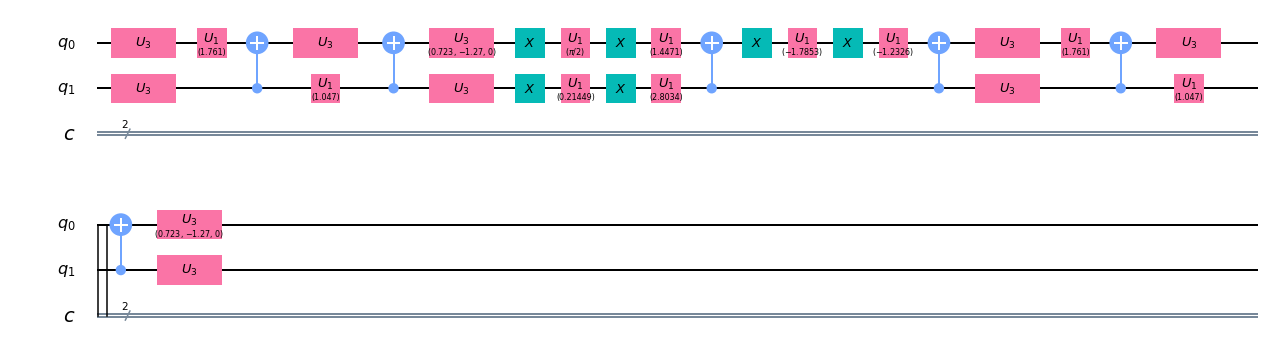

In [55]:
# Experiment

# Initialize
qr = QuantumRegister(2,'q')
cr = ClassicalRegister(2,'c')
circ = QuantumCircuit(qr,cr)
#circ.h(0)
#circ.draw()

# setting parameters
omega_tau=sym.pi/6
alpha = sym.pi/2

# Operations
circ = TimeForwardingProcess(circ)
circ = TimeReversalOperation(circ)
circ = TimeForwardingProcess(circ)


# Select the StatevectorSimulator from the Aer provider
simulator = Aer.get_backend('statevector_simulator')
# Execute and get counts
result = execute(circ , simulator).result()
statevector = result.get_statevector(circ)
#plot_state_city(statevector, title='Result')
#print(np.abs(statevector) )

print('|00> : {0:2.3f} %'.format(np.abs(statevector[0])**2*100))
print('|01> : {0:2.3f} %'.format(np.abs(statevector[1])**2*100))
print('|10> : {0:2.3f} %'.format(np.abs(statevector[2])**2*100))
print('|11> : {0:2.3f} %'.format(np.abs(statevector[3])**2*100))


circ.draw(output='mpl')